In this kernel we will go through a sentiment analysis on imdb dataset using LSTM.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install gensim==3.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from nltk.corpus import stopwords 
from collections import Counter
import nltk
nltk.download('stopwords')
import re
import seaborn as sns
from tqdm import tqdm

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch

# CURRENT_DIR = os.getcwd()
CURRENT_DIR = "/content/drive/MyDrive/CSE582-NLP-Assignment2-986195304"
INPUT_FILE = os.path.join(CURRENT_DIR, 'output','top_data_df_small.csv')
OUTPUT_FOLDER = os.path.join(CURRENT_DIR, 'output')

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [6]:
df = pd.read_csv(INPUT_FILE)
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1
1,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1
2,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1
3,6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1
4,7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1


### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [24]:
X,y = df['text'].values,df['stars'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (22500,)
shape of test data is (7500,)


### Analysing sentiment

### Tokenization

In [25]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received < 3:
        return 0
    # elif stars_received == 3:
    #     return 0
    else:
        return 1

In [26]:
# nltk.download('stopwords')
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [map_sentiment(label) for label in y_train]  
    encoded_test = [map_sentiment(label) for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [27]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

<ipython-input-26-a5aca38cc3cc>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [28]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

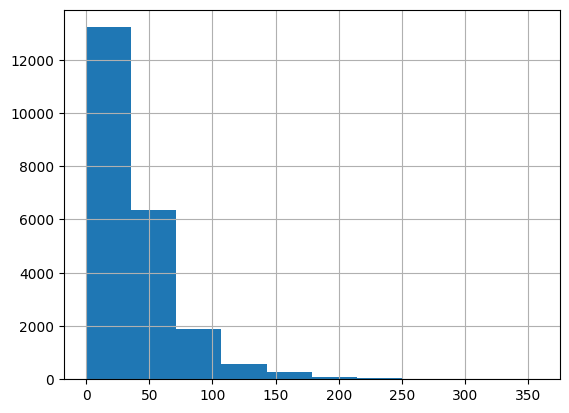

count    22500.000000
mean        39.573867
std         33.386377
min          0.000000
25%         17.000000
50%         30.000000
75%         50.000000
max        357.000000
dtype: float64

In [29]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations : <br>a) Mean review length = around 39.<br> b) minimum length of reviews is 0.<br>c)There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

### Padding

Now we will pad each of the sequence to max length 

In [30]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [31]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

### Batching and loading as tensor

In [32]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [33]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 167,  49,  11],
        [  0,   0,   0,  ..., 145,  52, 277],
        [  0,   0,   0,  ..., 201, 743, 274],
        ...,
        [  0,   0,   0,  ...,   5,  48,  11],
        [  0,   0,   0,  ...,  42, 453, 293],
        [  0,   0,   0,  ...,   3, 808,  38]])
Sample input: 
 tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Model

In [34]:
import gensim
class SentimentLSTM(nn.Module):
    
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
        super().__init__()
        # params: "n_" means dimension
        # self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM

         # embedding and LSTM layers
        w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
        weights = w2vmodel.wv
        self.n_vocab = len(w2vmodel.wv.vocab)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        
        # self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        
    def forward (self, input_words):
                                             # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h

    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

              

In [35]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
output_dim = 1
hidden_dim = 512

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, no_layers)

#moving to gpu
model.to(device)

print(model)


SentimentLSTM(
  (embedding): Embedding(26780, 500, padding_idx=1113)
  (lstm): LSTM(500, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Training

In [36]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [37]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
import time
for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        train_losses.append(loss.item())
        
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
  
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    end_time = time.time()
    print("Epoch" + str(epoch + 1))
    print(f'Train Loss : {epoch_train_loss}')
    print(f'Val Loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print("Time taken :"+ str(time.time() - start_time))
    if epoch_val_loss <= valid_loss_min:
        torch.save(model, os.path.join(OUTPUT_FOLDER, 'lstm_big_model_500_with_padding_tanh.pth'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch1
Train Loss : 0.5881873022185432
Val Loss : 0.638445676167806
train_accuracy : 69.88 val_accuracy : 65.60000000000001
Time taken :118.02641534805298
Validation loss decreased (inf --> 0.638446).  Saving model ...
Epoch2
Train Loss : 0.553299734128846
Val Loss : 0.6297680739561716
train_accuracy : 72.38222222222223 val_accuracy : 66.66666666666666
Time taken :122.54938888549805
Validation loss decreased (0.638446 --> 0.629768).  Saving model ...
Epoch3
Train Loss : 0.6252327808406618
Val Loss : 0.6313625391324361
train_accuracy : 66.26666666666667 val_accuracy : 66.8
Time taken :122.76624155044556
Epoch4
Train Loss : 0.6154550676875644
Val Loss : 0.5840439496437708
train_accuracy : 67.1511111111111 val_accuracy : 67.90666666666667
Time taken :122.9125120639801
Validation loss decreased (0.629768 --> 0.584044).  Saving model ...
Epoch5
Train Loss : 0.5919541688760122
Val Loss : 0.5756865890820821
train_accuracy : 68.95555555555556 val_accuracy : 68.53333333333333
Time taken :122.96

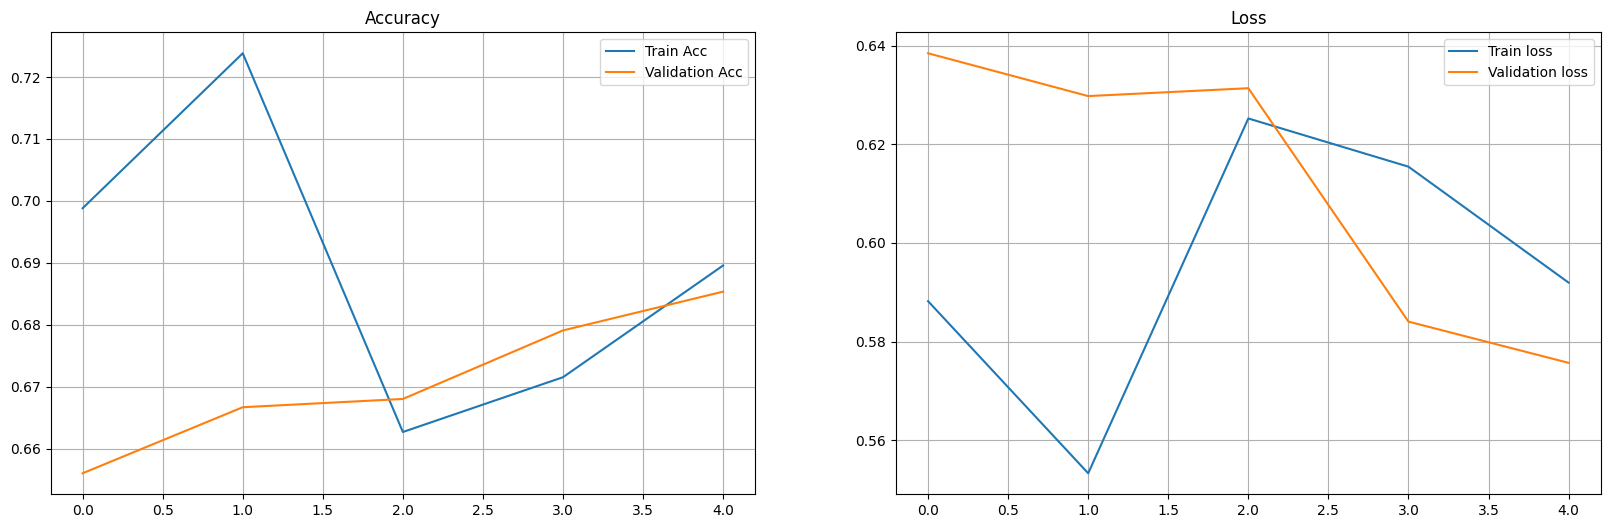

In [38]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Some improvement suggestions are as follow:

* Running a hyperparameter search to optimize your configurations.
* Using pretraned word embeddings like Glove word embeddings
* Increasing the model complexity like adding more layers/ using bidirectional LSTMs
